# Loading Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

# Importing Dataset

In [ ]:
import yfinance as yf
meta = yf.download("META",start='2012-05-18',end='2023-01-18',period='1d')

print(meta.info())

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2683 entries, 2012-05-18 00:00:00-04:00 to 2023-01-17 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2683 non-null   float64
 1   High       2683 non-null   float64
 2   Low        2683 non-null   float64
 3   Close      2683 non-null   float64
 4   Adj Close  2683 non-null   float64
 5   Volume     2683 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 211.3 KB
None


# Train Test Split

In [ ]:
meta.shape

(2683, 6)

In [ ]:
meta.index.min(), meta.index.max()

(Timestamp('2013-01-02 00:00:00-0500', tz='America/New_York'),
 Timestamp('2022-12-30 00:00:00-0500', tz='America/New_York'))

In [ ]:
tstart = 2012
tend = 2020

print(f'{tstart}')

2012


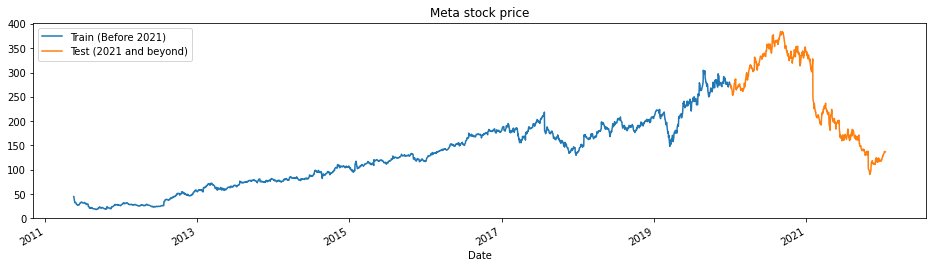

In [ ]:

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Meta stock price")
    plt.show()

train_test_plot(meta,tstart,tend)

In [ ]:
## Train and Test data split function
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(meta, tstart, tend)

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
training_set[1:61], training_set[61]

(array([[36.65999985],
        [33.59000015],
        [32.5       ],
        [33.20999908],
        [32.95000076],
        [31.69000053],
        [29.54999924],
        [29.67000008],
        [29.14999962],
        [27.64999962],
        [27.76000023],
        [27.17000008],
        [27.35000038],
        [27.76000023],
        [28.06999969],
        [27.77000046],
        [28.10000038],
        [28.31999969],
        [30.10000038],
        [32.08000183],
        [32.18000031],
        [31.93000031],
        [32.5       ],
        [33.45000076],
        [33.02000046],
        [33.43999863],
        [32.90000153],
        [32.18999863],
        [31.98999977],
        [31.72999954],
        [31.44000053],
        [31.62999916],
        [31.89999962],
        [32.88000107],
        [32.47999954],
        [31.55999947],
        [31.39999962],
        [31.06999969],
        [30.5       ],
        [28.59000015],
        [29.29000092],
        [29.5       ],
        [29.46999931],
        [29

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [ ]:
X_train.shape

(2110, 60, 1)

In [ ]:
## Printing the first record after sequencing
print(X_train[0])

## Number of input values in the each record
print("\n\nNumber of values in each record (features) :", len(X_train[0]))

[[0.01409036]
 [0.01489314]
 [0.01616654]
 [0.01854723]
 [0.01802126]
 [0.0207895 ]
 [0.02314251]
 [0.02455431]
 [0.02524637]
 [0.02386225]
 [0.02009744]
 [0.02029122]
 [0.02034659]
 [0.02159229]
 [0.02328092]
 [0.02325324]
 [0.02447127]
 [0.02607684]
 [0.02485882]
 [0.02325324]
 [0.02319787]
 [0.02195217]
 [0.01691397]
 [0.01624958]
 [0.01716311]
 [0.01677555]
 [0.01683092]
 [0.01547448]
 [0.01403499]
 [0.01447791]
 [0.01533606]
 [0.01566825]
 [0.01658177]
 [0.01649872]
 [0.0151146 ]
 [0.01256782]
 [0.0125955 ]
 [0.01209722]
 [0.01176503]
 [0.0116543 ]
 [0.01392426]
 [0.01375816]
 [0.01409036]
 [0.01395194]
 [0.01547448]
 [0.01489314]
 [0.01536375]
 [0.01447791]
 [0.01262319]
 [0.01201417]
 [0.01098992]
 [0.0102425 ]
 [0.010547  ]
 [0.00996568]
 [0.00836009]
 [0.00808327]
 [0.00750194]
 [0.0066161 ]
 [0.0088307 ]
 [0.00852619]]


Number of values in each record (features) : 60


In [ ]:
X_train.shape

(2110, 60, 1)

In [ ]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [ ]:
X_train.shape

(2110, 60, 1)

In [ ]:
X_train[0]

array([[0.093331  ],
       [0.06421089],
       [0.05349162],
       [0.04968575],
       [0.0521648 ],
       [0.05125698],
       [0.04685754],
       [0.03938547],
       [0.03980447],
       [0.03798882],
       [0.03275139],
       [0.03313547],
       [0.03107542],
       [0.03170391],
       [0.03313547],
       [0.03421787],
       [0.03317039],
       [0.03432262],
       [0.03509078],
       [0.04130586],
       [0.04821928],
       [0.04856843],
       [0.04769553],
       [0.04968575],
       [0.05300279],
       [0.05150139],
       [0.05296787],
       [0.0510824 ],
       [0.04860334],
       [0.04790502],
       [0.0469972 ],
       [0.04598464],
       [0.04664804],
       [0.04759078],
       [0.05101257],
       [0.04961592],
       [0.04640363],
       [0.04584497],
       [0.04469273],
       [0.04270251],
       [0.03603352],
       [0.03847765],
       [0.03921089],
       [0.03910614],
       [0.03746508],
       [0.03903631],
       [0.03917597],
       [0.034

#Model Building

## LSTM Model

In [ ]:
# The LSTM architecture
model_lstm = Sequential()

## RNN Layer
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))

## Output Layer
model_lstm.add(Dense(units=1))

# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [ ]:
## Fitting the model
model_lstm.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
66/66 [==============================] - 3s 46ms/step - loss: 0.0016
Epoch 2/25
66/66 [==============================] - 3s 43ms/step - loss: 9.3212e-04
Epoch 3/25
66/66 [==============================] - 3s 44ms/step - loss: 8.6475e-04
Epoch 4/25
66/66 [==============================] - 3s 43ms/step - loss: 7.9209e-04
Epoch 5/25
66/66 [==============================] - 3s 44ms/step - loss: 6.5042e-04
Epoch 6/25
66/66 [==============================] - 3s 44ms/step - loss: 5.6740e-04
Epoch 7/25
66/66 [==============================] - 3s 44ms/step - loss: 5.2227e-04
Epoch 8/25
66/66 [==============================] - 3s 44ms/step - loss: 4.4207e-04
Epoch 9/25
66/66 [==============================] - 3s 44ms/step - loss: 4.7392e-04
Epoch 10/25
66/66 [==============================] - 3s 43ms/step - loss: 4.1943e-04
Epoch 11/25
66/66 [==============================] - 4s 53ms/step - loss: 4.1789e-04
Epoch 12/25
66/66 [==============================] - 3s 44ms/step - loss: 4.01

In [ ]:
dataset_total = meta.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
print(type(input))

<class 'method'>


In [ ]:
inputs[:5]

array([260.17999268, 264.61999512, 264.75      , 280.17999268,
       279.1000061 ])

In [ ]:
inputs = inputs.reshape(-1, 1)

#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

17/17 [==============================] - 1s 16ms/step


In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Meta Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Meta Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

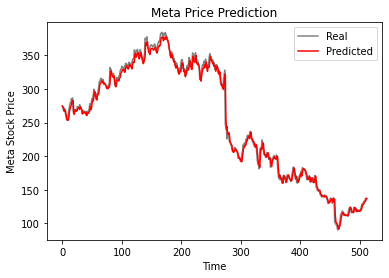

In [ ]:
plot_predictions(test_set,predicted_stock_price)

In [ ]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.02.


##GRU Model

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units=100, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               30900     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
66/66 [==============================] - 5s 42ms/step - loss: 0.0126
Epoch 2/25
66/66 [==============================] - 3s 42ms/step - loss: 0.0011
Epoch 3/25
66/66 [==============================] - 3s 43ms/step - loss: 7.0993e-04
Epoch 4/25
66/66 [==============================] - 3s 48ms/step - loss: 5.6119e-04
Epoch 5/25
66/66 [==============================] - 3s 43ms/step - loss: 5.2099e-04
Epoch 6/25
66/66 [==============================] - 3s 42ms/step - loss: 4.4173e-04
Epoch 7/25
66/66 [==============================] - 3s 41ms/step - loss: 4.0222e-04
Epoch 8/25
66/66 [==============================] - 3s 42ms/step - loss: 3.5912e-04
Epoch 9/25
66/66 [==============================] - 3s 42ms/step - loss: 3.7598e-04
Epoch 10/25
66/66 [==============================] - 3s 41ms/step - loss: 3.3263e-04
Epoch 11/25
66/66 [==============================] - 3s 41ms/step - loss: 3.0910e-04
Epoch 12/25
66/66 [==============================] - 3s 42ms/step - loss: 3.1064e-

17/17 [==============================] - 1s 13ms/step


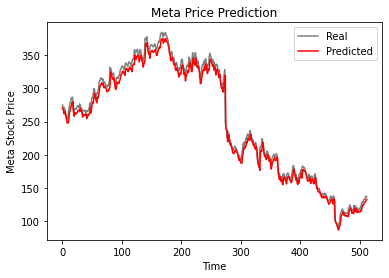

In [ ]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [ ]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 8.92.


##Bidirectional LSTM Model

In [ ]:
model_bid = Sequential()
model_bid.add(Bidirectional(LSTM(units=100, activation="tanh", input_shape=(n_steps, features))))
model_bid.add(Dense(units=1))
# Compiling the RNN
model_bid.compile(optimizer="RMSprop", loss="mse")

In [ ]:
model_bid.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
66/66 [==============================] - 10s 71ms/step - loss: 0.0056
Epoch 2/25
66/66 [==============================] - 6s 94ms/step - loss: 0.0015
Epoch 3/25
66/66 [==============================] - 5s 71ms/step - loss: 0.0012
Epoch 4/25
66/66 [==============================] - 5s 70ms/step - loss: 9.5210e-04
Epoch 5/25
66/66 [==============================] - 6s 90ms/step - loss: 8.5602e-04
Epoch 6/25
66/66 [==============================] - 5s 71ms/step - loss: 7.7062e-04
Epoch 7/25
66/66 [==============================] - 5s 70ms/step - loss: 6.7319e-04
Epoch 8/25
66/66 [==============================] - 5s 70ms/step - loss: 5.9189e-04
Epoch 9/25
66/66 [==============================] - 5s 70ms/step - loss: 6.0666e-04
Epoch 10/25
66/66 [==============================] - 5s 71ms/step - loss: 5.2667e-04
Epoch 11/25
66/66 [==============================] - 5s 71ms/step - loss: 5.2072e-04
Epoch 12/25
66/66 [==============================] - 5s 71ms/step - loss: 4.9766e-04


17/17 [==============================] - 1s 20ms/step


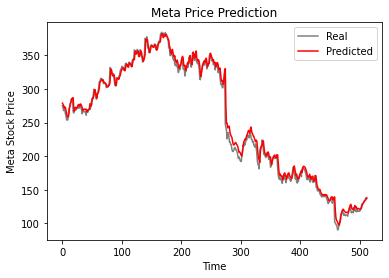

In [ ]:
BID_predicted_stock_price = model_bid.predict(X_test)
BID_predicted_stock_price = sc.inverse_transform(BID_predicted_stock_price)
plot_predictions(test_set, BID_predicted_stock_price)

In [ ]:
return_rmse(test_set,BID_predicted_stock_price)

The root mean squared error is 8.00.


## LSTM model gives best model with RMSE of 7.02